In [1]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

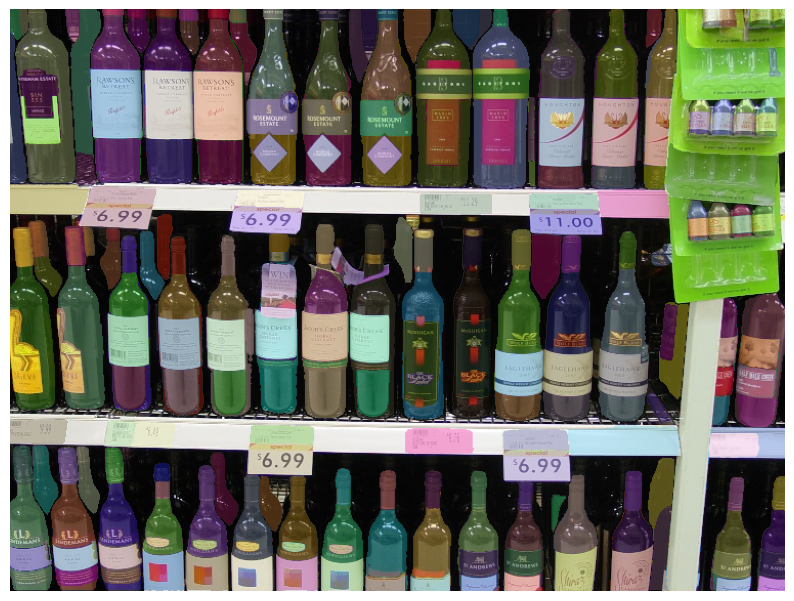

In [3]:
def show_saved_maskes(name="db932"):
    dir = f"../data/product_detection_from_packshots/shelf_masks/{name}"
    n = len(os.listdir(dir))//7
    masks_list = []
    image_path = f"../data/product_detection_from_packshots/shelf_images/{name}.jpg"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
    for num in range(0, n):
        np_segmentation = np.load(f"{dir}/segmentation_{num}.npy")
        np_area = np.load(f"{dir}/area_{num}.npy")
        np_bbox = np.load(f"{dir}/bbox_{num}.npy")
        np_predicted_iou = np.load(f"{dir}/predicted_iou_{num}.npy")
        np_point_coords = np.load(f"{dir}/point_coords_{num}.npy")
        np_stability_score = np.load(f"{dir}/stability_score_{num}.npy")
        np_crop_box = np.load(f"{dir}/crop_box_{num}.npy")
        masks_list.append({
          'segmentation': np_segmentation,
          'area':np_area, 
          'bbox':np_bbox, 
          'predicted_iou':np_predicted_iou, 
          'point_coords':np_point_coords, 
          'stability_score':np_stability_score, 
          'crop_box':np_crop_box
        })

    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_anns(masks_list)
    plt.axis('off')
    plt.show()

    return masks_list, image
    
masks_list, image = show_saved_maskes(name="db932")

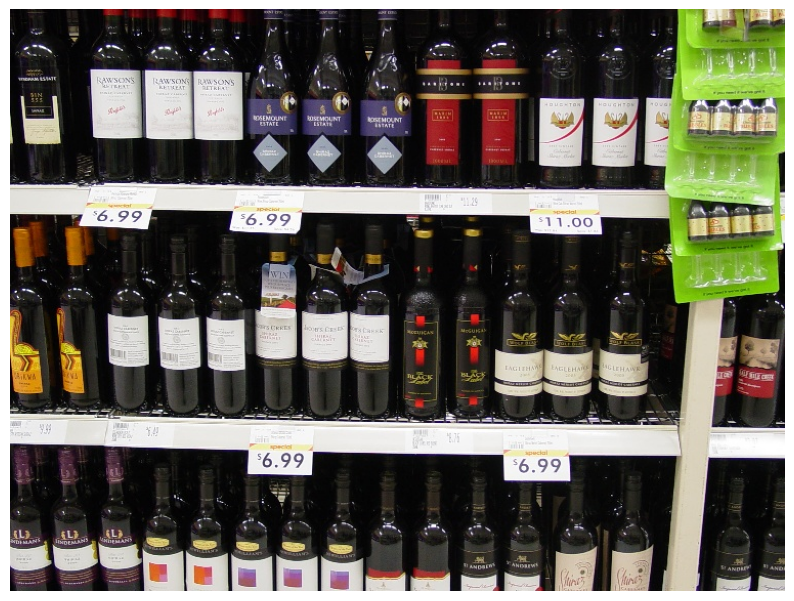

In [4]:
plt.figure(figsize=(10,10))
#plt.imshow(masks_list[0]['segmentation'])
plt.imshow(image)
plt.axis('off')
plt.show()

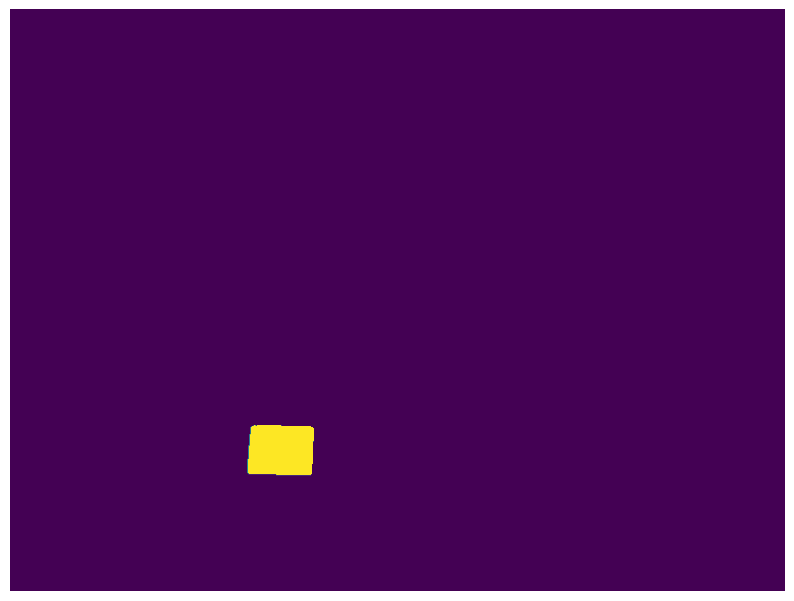

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(masks_list[0]['segmentation'])
#plt.imshow(image)
plt.axis('off')
plt.show()

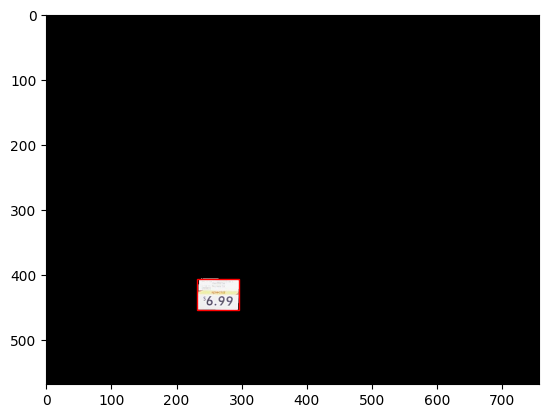

In [6]:
#Black Out rest of the image
mask_image = masks_list[0]['segmentation']
mask3d = np.dstack([mask_image]*3)
cut_out_mask = np.invert(mask3d)
cutout_image = np.where(cut_out_mask, 0, image)

#draw rectangle
bbox = masks_list[0]['bbox']
x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]

plt.gca().add_patch(Rectangle((232,406),w,h,linewidth=1,edgecolor='r',facecolor='none'))
plt.imshow(cutout_image)

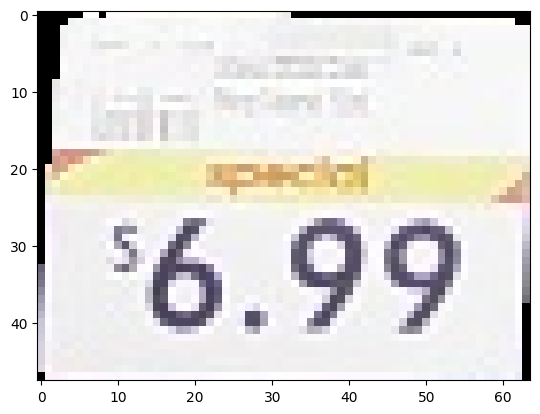

In [7]:
bbox = masks_list[0]['bbox']
x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
cropped_image = cutout_image[y:y+h, x:x+w]
plt.imshow(cropped_image)

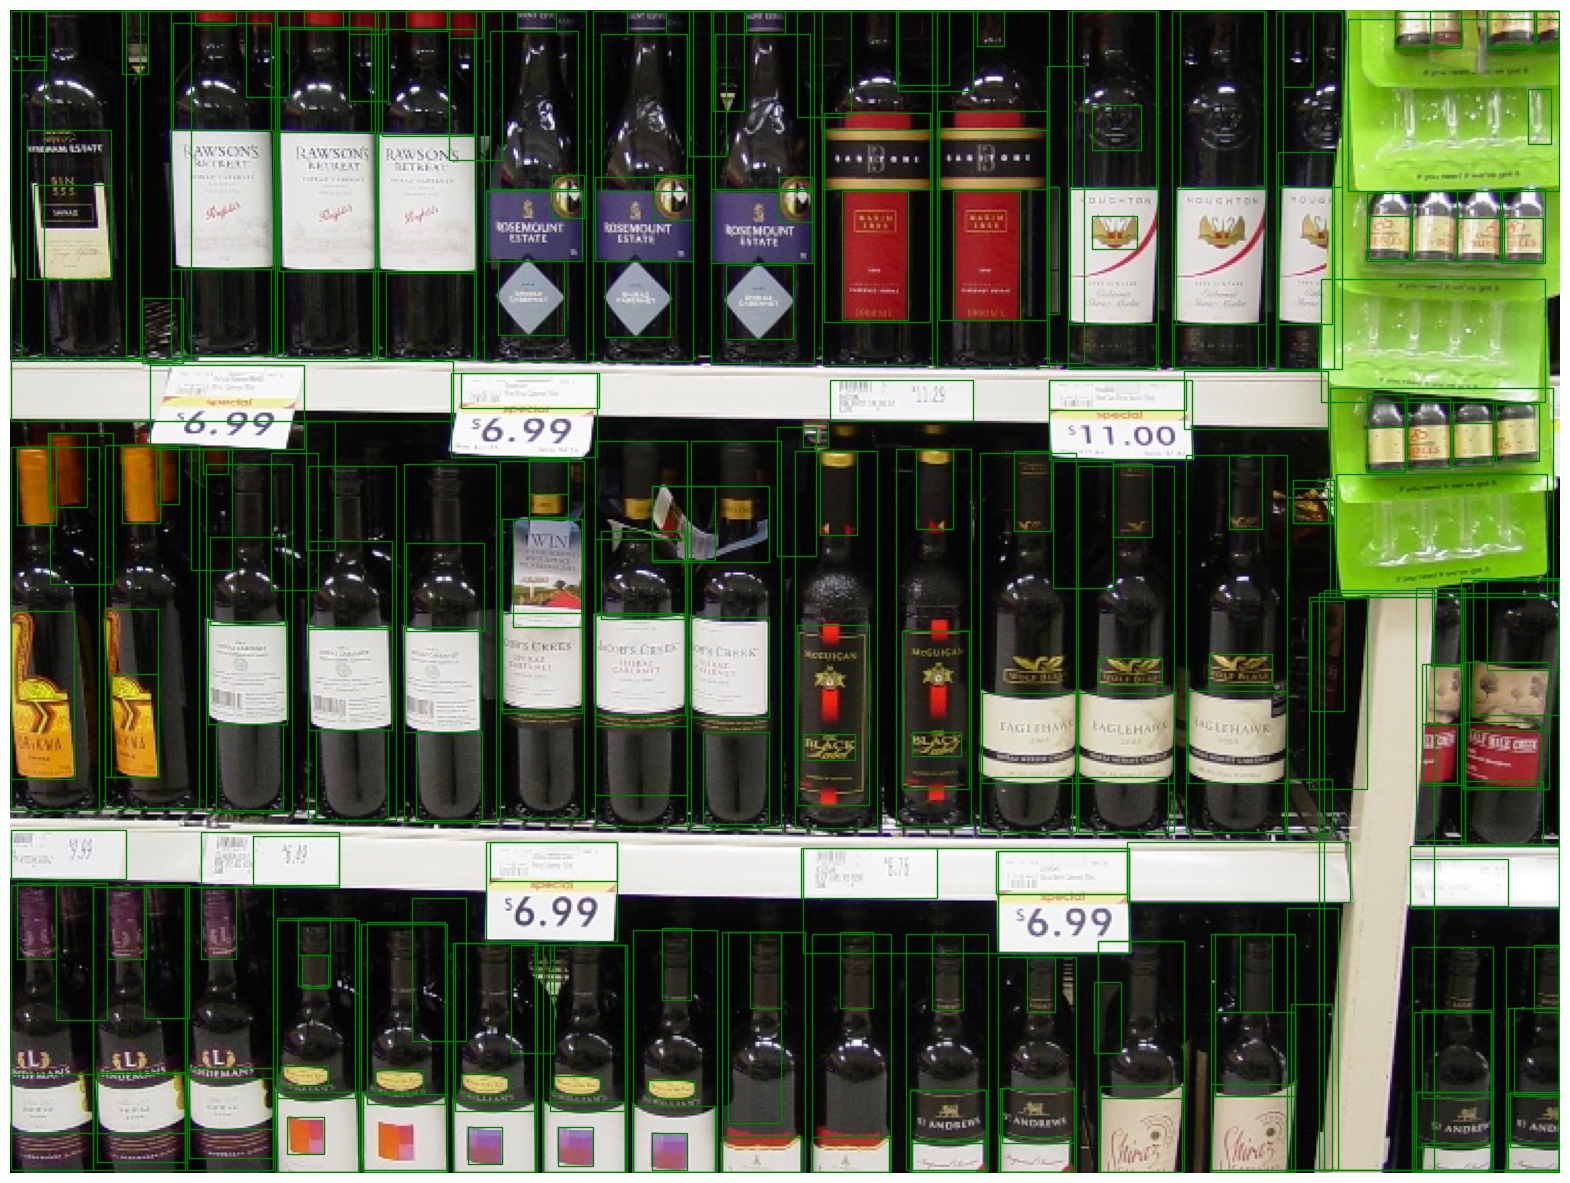

In [8]:
def show_saved_bboxes(name="db932"):
    dir = f"../data/product_detection_from_packshots/shelf_masks/{name}"
    n = len(os.listdir(dir))//7a
    image_path = f"../data/product_detection_from_packshots/shelf_images/{name}.jpg"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,20))

    for num in range(0, n):
        np_bbox = np.load(f"{dir}/bbox_{num}.npy")
        x0, y0 = np_bbox[0], np_bbox[1]
        w, h = np_bbox[2], np_bbox[3]
        plt.gca().add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1))
        
    plt.imshow(image)
    #show_anns(masks_list)
    plt.axis('off')
    plt.show()
show_saved_bboxes(name="db932")

In [32]:
def dump_cropped_masks_of_shelf(name):
    start_time = time.time()
    dir = f"../data/product_detection_from_packshots/shelf_masks/{name}"
    
    n = len(os.listdir(dir))//7
    image_path = f"../data/product_detection_from_packshots/shelf_images/{name}.jpg"
    image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_masks_dir = f"../data/product_detection_from_packshots/shelf_cropped_masks_images/{name}"
    if not os.path.exists(cropped_masks_dir):
        os.makedirs(cropped_masks_dir, exist_ok=True)
        for num in range(0, n):
            try:
                #print(f"Dumped: {num}/{n}")
                mask_image = np.load(f"{dir}/segmentation_{num}.npy")
                np_bbox = np.load(f"{dir}/bbox_{num}.npy")
                x, y, w, h  = np_bbox[0], np_bbox[1], np_bbox[2], np_bbox[3]
                
                #Black Out rest of the image
                mask3d = np.dstack([mask_image]*3)
                cut_out_mask = np.invert(mask3d)
                cutout_image = np.where(cut_out_mask, 0, image)
                cropped_image = cutout_image[y:y+h, x:x+w]
                cv2.imwrite(f"{cropped_masks_dir}/{num}.jpg", cropped_image)
            except Exception as e:
                print(f"Error: {e} for {name}/{num} | total_objects: {n}")
        end_time = time.time()
        print(f"Shelf {name}: {n} objects | time: {end_time-start_time}")
    else:
        print(f"Dir: {name} exists, skipping {name}")


In [33]:
for file in os.listdir(f"../data/product_detection_from_packshots/shelf_images"):
    name = file.split(".")[0]
    dump_cropped_masks_of_shelf(name)

Shelf db1: 209 objects | time: 1.6263716220855713
Dir: db10 exists, skipping db10
Dir: db100 exists, skipping db100
Dir: db1000 exists, skipping db1000
Dir: db1001 exists, skipping db1001
Dir: db1002 exists, skipping db1002
Dir: db1003 exists, skipping db1003
Dir: db1004 exists, skipping db1004
Dir: db1005 exists, skipping db1005
Dir: db1006 exists, skipping db1006
Dir: db1007 exists, skipping db1007
Dir: db1008 exists, skipping db1008
Dir: db1009 exists, skipping db1009
Dir: db101 exists, skipping db101
Dir: db1010 exists, skipping db1010
Dir: db1011 exists, skipping db1011
Dir: db1012 exists, skipping db1012
Dir: db1013 exists, skipping db1013
Dir: db1014 exists, skipping db1014
Dir: db1015 exists, skipping db1015
Shelf db1016: 211 objects | time: 1.5926272869110107
Error: slice indices must be integers or None or have an __index__ method for db1017/0 | total_objects: 198
Error: slice indices must be integers or None or have an __index__ method for db1017/1 | total_objects: 198
Error